In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import geopandas as gpd
import albumentations as albu
import zipfile
from shapely.geometry import MultiPolygon, shape, box
from pyproj import Proj, transform as coord_transform
import fiona
import rasterio
import json
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
x_train_dir = '../../../../net/projects/cmap/data/KC-images'
y_train_dir = '../../../../net/projects/cmap/data/KC-masking'

In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [25]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ["pond", "wetland", "dry bottom - turf", "dry bottom - mesic prairie"]

    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. pond)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [35]:
# Define the path to the image file
#image_path = os.path.join(x_train_dir, 'm_4108814_ne_16_060_20210928.tif')
# Create empty lists for mask and image paths
mask_paths = []
image_paths = []

#Specify valid labels
valid_basin_types = ["POND", "WETLAND", "DRY BOTTOM - TURF", "DRY BOTTOM - MESIC PRAIRIE"]

# Specify the selected layer and the path to the geodatabase
selected_layer = 'WTR_Countywide_Stormwater_Storage'
gdb_path = "../data/KC_StormwaterDataJan2024.gdb"

# List all available layers in the geodatabase
layers = fiona.listlayers(gdb_path)

# Read the specified layer into a GeoDataFrame
gdf = gpd.read_file(gdb_path, layer=selected_layer)

for filename in os.listdir(x_train_dir):
    # Full path to the file
    image_path = os.path.join(x_train_dir, filename)# Check if the image file exists; if not, skip the annotation
    if image_path is None or not os.path.isfile(image_path):
        print(f"No file {image_path} found -- skipping this annotation")
        # Add any necessary handling for missing image files

    # Open the raster image using rasterio
    src = rasterio.open(image_path)

    # Create a bounding box from the raster image bounds
    bbox = box(*src.bounds)
    geo_frame = gdf.copy()

    # Reproject the GeoDataFrame to match the raster CRS
    geo_frame = geo_frame.to_crs(src.crs)

    # Filter the GeoDataFrame to intersect with the bounding box
    geo_frame = geo_frame[geo_frame["geometry"].intersects(bbox)]

    # Define valid basin types and filter the GeoDataFrame
    geo_frame = geo_frame[geo_frame["BasinType"].isin(valid_basin_types)]

    # Read the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Define the mask path
    mask_path = os.path.abspath(image_path).replace('KC-images', 'KC-masking')
    #head, tail = os.path.splitext(mask_path)
    #mask_path = head + "_mask" + tail

    # Get the initial mask outside the loop
    mask = np.zeros(img.shape[:2], np.uint8)

    # Extract bounding box coordinates
    min_x = int(bbox.bounds[0])
    min_y = int(bbox.bounds[1])
    dif_x = int(bbox.bounds[2]) - min_x
    dif_y = int(bbox.bounds[3]) - min_y

    class_colors = {
        "POND": 2,  # Red
        "WETLAND": 3,  # Green
        "DRY BOTTOM - TURF": 4,  # Blue
        "DRY BOTTOM - MESIC PRAIRIE": 5,  # Yellow
    }
    # Iterate through each row in the GeoDataFrame
    for index, row in geo_frame.iterrows():
        # Extract coordinates from the geometry
        img_annotation_chunks = row['geometry'].geoms[0].exterior.coords

        # Convert coordinates to NumPy array and adjust for image dimensions
        coords = np.array(img_annotation_chunks)
        coords = coords.astype(np.int32)
        coords[:, 0] = (coords[:, 0] - min_x) * (img.shape[1] / dif_x)
        coords[:, 1] = (dif_y - (coords[:, 1] - min_y)) * (img.shape[0] / dif_y)

        # Create a temporary mask and fill it with the polygon defined by the coordinates
        temp_mask = np.zeros(img.shape[:2], np.uint8)
        cv2.fillPoly(temp_mask, [coords], class_colors.get(row.BasinType), 0)

        # Combine the temporary mask with the overall mask
        mask = cv2.bitwise_or(mask, temp_mask)

    # Set all pixels in the image to white
    img[:, :] = 1
    # Apply the mask to the image
    img = cv2.bitwise_and(img, img, mask=mask)
    img = mask
    # Move the directory creation and image writing outside the loop
    os.makedirs(os.path.dirname(mask_path), exist_ok=True)
    cv2.imwrite(mask_path, img)

    # Append paths to the lists
    mask_paths.append(mask_path)
    image_paths.append(image_path)

    # Display the list of mask paths
    mask_paths



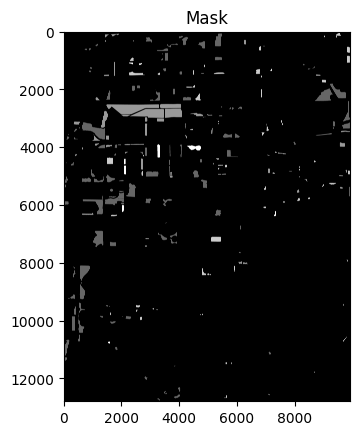

In [8]:
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

In [32]:
classes = ["POND", "WETLAND", "DRY BOTTOM - TURF", "DRY BOTTOM - MESIC PRAIRIE"]
currClass = "DRY BOTTOM - TURF"
dataset = Dataset(x_train_dir, y_train_dir, classes = [currClass])

image, mask = dataset[0] # get some sample

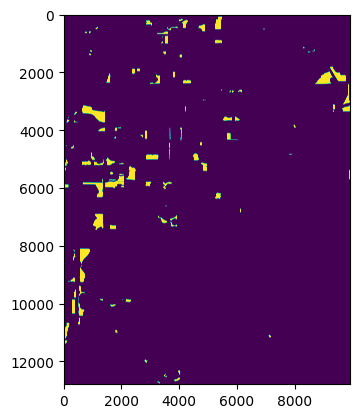

In [33]:
plt.imshow(mask.squeeze())
plt.title(currClass)

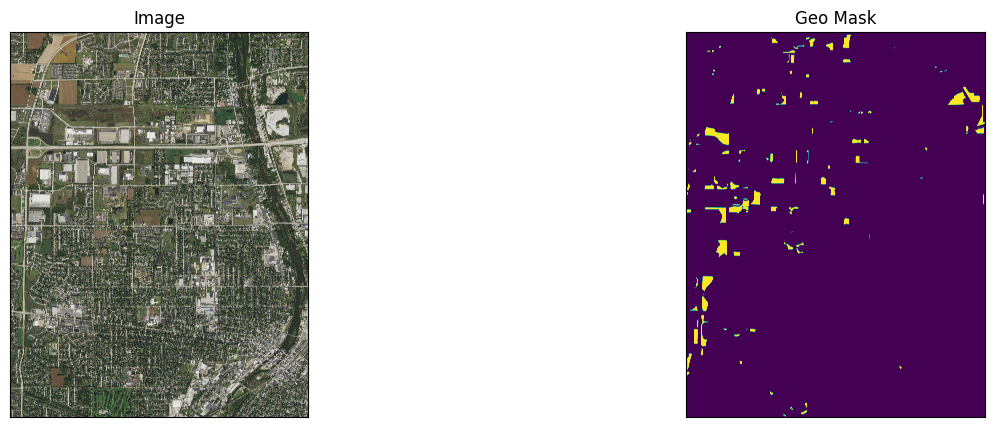

In [34]:
visualize(
    image=image, 
    geo_mask=mask.squeeze(),
)

In [19]:
cv2.imread("y_train_dir/m_4108814_sw_16_060_20210928_mask.tif", 0)

[ WARN:0@970.797] global loadsave.cpp:248 findDecoder imread_('y_train_dir/m_4108814_sw_16_060_20210928_mask.tif'): can't open/read file: check file path/integrity


# Comparison of feature mapping

(390725.4, 4629469.2, 396575.4, 4637029.8)


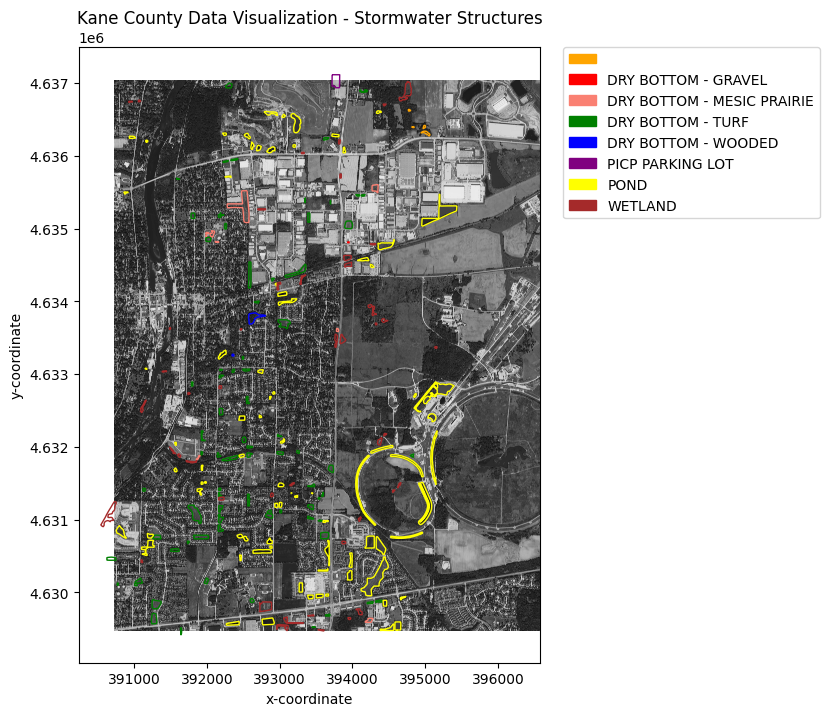

In [37]:
import rasterio.plot
import matplotlib.patches as mpatches
from shapely.geometry import box
import matplotlib.pyplot as plt
%matplotlib inline
fp = "/net/projects/cmap/data/KC-images/m_4108814_ne_16_060_20210928.tif"
src = rasterio.open(fp)

kc = gpd.read_file("/net/projects/cmap/data/kane-county-data/KC_StormwaterDataJan2024.gdb.zip", layer="WTR_Countywide_Stormwater_Storage")
kc = kc.to_crs(src.crs)
kc["BasinType"].value_counts()



fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show((src, 1), ax=ax, cmap="gray")

bbox = box(*src.bounds)
print(bbox.bounds)
intersecting_pts = kc.drop(kc[~kc["geometry"].intersects(bbox)].index)
basin_types = intersecting_pts.groupby("BasinType")

color_map = {}
patches = []
colors = ['orange', 'red', 'salmon', 'green', 'blue', 'purple', 'yellow', 'brown', 'pink', 'gray']
i = 0
for basin_type, _ in basin_types:
    color_map[basin_type] = colors[i]
    patches.append(mpatches.Patch(color=colors[i], label=basin_type))
    i += 1
for basin_type, shapes in basin_types:
    shapes.plot(ax=ax, facecolor="none", label=basin_type.lower, edgecolor=color_map[basin_type])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Kane County Data Visualization - Stormwater Structures")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
kc

,Function_,BasinType,Manmade,ADID,OwnerType,Owner,Outlet_Str,Last_Insp,Notes,AddUser,...,PHRAGMITES,CATTAILS,MAINTENANCE,RETROFIT,WQ_FUNCTION,Aeration,FldStorage,Shape_Length,Shape_Area,geometry
0,AGRICULTURAL,POND,YES,YES,PRIVATE,Landowner,,1899-12-30 00:00:01+00:00,Farm Pond,,...,None,None,None,None,None,None,None,776.704786,26103.207615,"MULTIPOLYGON (((377884.864 4648669.285, 377881..."
1,STORMWATER,DRY BOTTOM - TURF,YES,No,PRIVATE,,YES,1899-12-30 00:00:01+00:00,Stormwater basin north end of Sumerset Subdivi...,,...,None,None,None,None,None,None,None,690.647980,28373.350311,"MULTIPOLYGON (((381349.384 4647096.334, 381342..."
2,STORMWATER,POND,YES,No,PRIVATE,MULTIPLE LANDOWNERS,YES,1899-12-30 00:00:01+00:00,Sunset Views HOA,,...,None,None,None,None,None,None,None,1390.440121,55652.573809,"MULTIPOLYGON (((378164.024 4646072.932, 378160..."
3,STORMWATER,POND,YES,No,PRIVATE,MULTIPLE LANDOWNERS,YES,1899-12-30 00:00:01+00:00,Sunset Views HOA,,...,None,None,None,None,None,None,None,1639.548970,76710.776685,"MULTIPOLYGON (((378577.339 4645855.247, 378574..."
4,STORMWATER,POND,YES,NO,PRIVATE,Sunset Views HOA,YES,1899-12-30 00:00:01+00:00,Sunset Views HOA,,...,None,None,None,None,None,None,None,2115.081120,116225.262790,"MULTIPOLYGON (((378275.506 4645722.062, 378281..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5362,STORMWATER,DRY BOTTOM - TURF,YES,None,PRIVATE,None,YES,NaT,VERIFY EXACT DATE BUILT,WREREL,...,None,None,None,None,None,None,None,174.180901,2262.436089,"MULTIPOLYGON (((392677.598 4637593.259, 392678..."
5363,STORMWATER,WETLAND,YES,NO,PRIVATE,None,YES,NaT,NEW BASIN FOR MENARDS LUMBER YARD EXPANSION,WREREL,...,None,None,None,None,None,None,None,686.824390,32567.504786,"MULTIPOLYGON (((388871.829 4634435.754, 388875..."
5364,STORMWATER,WETLAND,YES,None,PRIVATE,None,YES,NaT,None,WREREL,...,None,None,None,None,None,None,None,1514.823785,50469.221205,"MULTIPOLYGON (((388950.513 4634442.285, 388961..."
5365,STORMWATER,DRY BOTTOM - MESIC PRAIRIE,YES,NO,PUBLIC,BATAVIA PARK DISTRICT,YES,NaT,VERIFY DETENTION AND NOT A PARKING LOT BMP,WREREL,...,None,None,None,None,None,None,None,245.093872,2929.441663,"MULTIPOLYGON (((389637.928 4633445.448, 389638..."
